## Interference-Aware Scheduling to Avoid SLO Violations

This notebook builds our SLO-Aware, Interference-Conscious scheduling pipeline.  
We will:

1. **Ingest** raw performance (wrk2) and hardware-counter (PCM) data.  
2. **Profile** each interference scenario by aggregating PCM metrics into summary features.  
3. **Join** these features with the observed P99-latencies to form our ML dataset.  
4. **Preprocess** the features (scaling, polynomial expansion) and construct a reusable pipeline.  
5. **Train & Evaluate** multiple regression models (linear+poly, Random Forest, kNN) using leave-one-out CV.  
6. **Select** the best model to compute our `RiskScore = predicted_P99 / SLO_threshold`, which will guide scheduling decisions.


In [1]:
import os
import pandas as pd
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import numpy as np
import json
import base64
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


### 1.1 Fetch Data

In [2]:
# Define the local path to store the CSV files from the LabPC
local_results_folder = Path("./Nginx_Data3")

# Create the folder if it does not already exist
local_results_folder.mkdir(parents=True, exist_ok=True)

print(f"Local results folder set to: {local_results_folder.resolve()}")



Local results folder set to: /home/george/Workshop/Interference/profiling/Nginx_Data3


In [30]:
# Check if the folder exists and delete all files inside it

if local_results_folder.exists():
    for file in local_results_folder.iterdir():
        if file.is_file():
            file.unlink()
    print("All files in the folder have been deleted.")


All files in the folder have been deleted.


In [3]:
# Replace 'george@147.102.13.77' and the remote path with your actual credentials and remote paths
remote_path = "george@147.102.13.77:/home/george/Workspace/NEW_V03/*"

# Use shell command to securely copy all CSV files from remote
!scp {remote_path} {str(local_results_folder)}/ 

# enter passphrase for the remote server


pcm_core_1replicas_scenario0_100rps.csv       100% 6187   275.9KB/s   00:00    
pcm_core_1replicas_scenario0_1100rps.csv      100% 6187   483.4KB/s   00:00    
pcm_core_1replicas_scenario0_1600rps.csv      100% 6187    57.6KB/s   00:00    
pcm_core_1replicas_scenario0_2100rps.csv      100% 6187   418.3KB/s   00:00    
pcm_core_1replicas_scenario0_2600rps.csv      100% 6187   453.2KB/s   00:00    
pcm_core_1replicas_scenario0_600rps.csv       100% 6187   432.8KB/s   00:00    
pcm_core_1replicas_scenario10_100rps.csv      100% 6187   348.6KB/s   00:00    
pcm_core_1replicas_scenario10_1100rps.csv     100% 6187   371.4KB/s   00:00    
pcm_core_1replicas_scenario10_1600rps.csv     100% 6187    51.3KB/s   00:00    
pcm_core_1replicas_scenario10_2100rps.csv     100% 6187   458.9KB/s   00:00    
pcm_core_1replicas_scenario10_2600rps.csv     100% 6187   419.7KB/s   00:00    
pcm_core_1replicas_scenario10_600rps.csv      100% 6187   374.3KB/s   00:00    
pcm_core_1replicas_scenario1_100rps.csv 

In [33]:
# List all CSV files in the local_results_folder
csv_files = list(local_results_folder.glob("*.csv"))

if not csv_files:
    print("No CSV files found in the directory. Check SCP or paths.")
else:
    for f in csv_files:
        # Number of rows and columns in the CSV file
        num_rows = sum(1 for _ in open(f))
        num_cols = len(pd.read_csv(f, nrows=0).columns)
        print(f"File: {f.name}, Rows: {num_rows}, Columns: {num_cols}")


File: pcm_system_1replicas_scenario12_100rps.csv, Rows: 10, Columns: 14
File: pcm_core_1replicas_scenario3_2500rps.csv, Rows: 10, Columns: 72
File: pcm_system_1replicas_scenario7_1700rps.csv, Rows: 10, Columns: 14
File: pcm_core_4replicas_scenario0_100rps.csv, Rows: 10, Columns: 72
File: pcm_system_2replicas_scenario12_900rps.csv, Rows: 13, Columns: 14
File: pcm_system_5replicas_scenario2_100rps.csv, Rows: 13, Columns: 14
File: pcm_core_4replicas_scenario5_900rps.csv, Rows: 13, Columns: 72
File: pcm_core_3replicas_scenario6_2500rps.csv, Rows: 13, Columns: 72
File: pcm_system_1replicas_scenario4_900rps.csv, Rows: 10, Columns: 14
File: pcm_core_2replicas_scenario1_900rps.csv, Rows: 13, Columns: 72
File: pcm_system_4replicas_scenario3_1300rps.csv, Rows: 13, Columns: 14
File: pcm_core_1replicas_scenario1_2500rps.csv, Rows: 10, Columns: 72
File: pcm_core_2replicas_scenario12_2500rps.csv, Rows: 13, Columns: 72
File: pcm_core_5replicas_scenario9_2100rps.csv, Rows: 13, Columns: 72
File: pcm_sy

### 1.2 View Data

In [25]:
file_patterns = {
    #"perf": "*perf*.csv",
    "pcm_system": "*pcm_system*.csv",
    "pcm_cores": "*pcm_core*.csv",
    #"container_detail": "*container_metrics_detail*.csv",
    #"container_agg": "*container_metrics_agg*.csv",
    "workload": "*workload*.csv",
}

In [26]:
interference_snenarios = ["baseline", "cpu_1_pod", "cpu_2_pod", "cpu_4_pod", "cpu_8_pod", "l3_1_pod", "l3_2_pod", "l3_4_pod", "membw_1_pod", "membw_2_pod", "membw_4_pod", "membw_8_pod"]

#### Example of each data file

In [27]:
# Loop through each category and find the first matching CSV file.
for category, pattern in file_patterns.items():
    # Construct the search pattern
    search_pattern = os.path.join(local_results_folder, pattern)
    matching_files = glob.glob(search_pattern)
    
    # Check if there is at least one matching file
    if matching_files:
        # Select the first matching file
        selected_file = matching_files[0]
        
        # Read the CSV into a DataFrame
        df = pd.read_csv(selected_file)
        
        # Optionally, re-save the file with comma as separator and without the index.
        # If you prefer to keep the original file intact, you can comment out the next line.
        df.to_csv(selected_file, sep=",", index=False)
        
        print(f"=== Category: {category} - File: {os.path.basename(selected_file)} ===")
        display(df.head(5))  # Use display() if you're in a Jupyter Notebook, otherwise use print(df.head(5))
        print("\n")
    else:
        print(f"No file found for the category: {category}\n")

No file found for the category: pcm_system

No file found for the category: pcm_cores

No file found for the category: workload



#### Columns in each data file

In [28]:
# Show the list of columns for each category
for category, pattern in file_patterns.items():
    # Construct the search pattern
    search_pattern = os.path.join(local_results_folder, pattern)
    matching_files = glob.glob(search_pattern)
    
    # Check if there is at least one matching file
    if matching_files:
        # Select the first matching file
        selected_file = matching_files[0]
        
        # Read the CSV into a DataFrame
        df = pd.read_csv(selected_file)
        
        print(f"=== Category: {category} - File: {os.path.basename(selected_file)} ===")
        print(df.columns.tolist())
        print("\n")
    else:
        print(f"No file found for the category: {category}\n")

No file found for the category: pcm_system

No file found for the category: pcm_cores

No file found for the category: workload



### 1.3 Load Data into Dataframes

In [4]:
Data_Dir_HR = 'HR_Data'
Data_Dir_Nginx = 'Nginx_Data3'
Data_Dir = Data_Dir_Nginx
#traffic = 'TC-VM-01'
Perfomance_File = os.path.join(Data_Dir, 'workload_metrics.csv')


if os.path.exists(Perfomance_File):
    df_perf = pd.read_csv(Perfomance_File)
    print("Loaded performance metrics:")
    display(df_perf.head())
    print(df_perf.shape)
else:
    print(f"Performance file not found at {Perfomance_File}. Please verify path.")
    df_perf = pd.DataFrame()



Loaded performance metrics:


,Test_ID,Replicas,Interference,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency
0,1replicas_scenario0_100rps,1,Baseline0,100,95.60,613.27,454.0,814.0,1270.0,1990.0,2400.0
1,1replicas_scenario0_600rps,1,Baseline0,600,596.00,81.46,64.0,93.0,128.0,319.0,1550.0
2,1replicas_scenario0_1100rps,1,Baseline0,1100,1074.04,527.54,412.0,677.0,1060.0,1710.0,2720.0
3,1replicas_scenario0_1600rps,1,Baseline0,1600,1563.95,400.84,321.0,486.0,754.0,1520.0,3650.0
4,1replicas_scenario0_2100rps,1,Baseline0,2100,2093.68,86.96,76.0,100.0,132.0,229.0,3600.0


(336, 11)


In [5]:
## For PCM Files

# Helper to clean column names
def clean_col(col):
    col = col.replace('System - ', '')
    col = col.replace('System Core C-States - ', 'core_c_')
    col = col.replace('System Pack C-States - ', 'pack_c_')
    col = col.replace(' ', '_').replace('-', '').lower()
    return col

## 2. Perfomance

1) Normalized Throughput Performance (NTP)

   Definition:
     NTP = Measured_Throughput / Baseline_Throughput

   Parameters:
   - Measured_Throughput: The throughput of the workload under interference (e.g., "Throughput" field in the CSV for a given scenario).
   - Baseline_Throughput: The throughput of the workload under the baseline (no interference). Typically, this is the “Throughput” value from a row where "Interference" = "baseline".

   Interpretation:
   - NTP > 1  => Application throughput exceeded the baseline
   - NTP < 1  => Application throughput degraded relative to baseline
   - NTP = 1  => No observed change vs. baseline


2) Normalized Latency Performance (NLP)

   Definition:
     NLP = Measured_Latency / Baseline_Latency

   Parameters:
   - Measured_Latency: A latency statistic (e.g., "Avg_Latency", "P90_Latency", "P99_Latency") for the scenario under interference.
   - Baseline_Latency: The corresponding latency statistic from the baseline scenario (where "Interference" = "baseline").

   Interpretation:
   - NLP > 1  => Latency is higher (worse) than baseline
   - NLP < 1  => Latency is lower (better) than baseline
   - NLP = 1  => No change in latency vs. baseline

   Note:
   You may apply NLP to any latency metric: P50, P75, P90, P99, etc. Choose whichever best suits your SLA or QoS focus.


3) QoS Degradation

   Definition (as a % increase in latency):
     QoS Degradation(%) = ((Measured_Latency - Baseline_Latency) / Baseline_Latency) * 100

   Parameters:
   - Measured_Latency: The same “Avg_Latency” or tail latency (e.g., "P99_Latency") under interference.
   - Baseline_Latency: The same latency value in the baseline scenario.

   Interpretation:
   - A positive value indicates how many percentage points slower the application is compared to the baseline.
   - Example: If baseline latency is 100 ms, and measured latency is 150 ms, QoS Degradation = ((150 - 100) / 100) * 100 = 50%


4) SLA Violations

   Definition:
     SLA Violations measure how often a latency threshold (e.g., “P99_Latency < 200 ms”) is exceeded.

   Common Calculation Approach:
     - Choose a latency statistic relevant to your SLA (e.g., P90, P99, or Max_Latency).
     - Define an SLA threshold T (e.g., 200 ms for P99 latency).
     - Count how many runs (or samples) exceed that threshold.
       SLA_Violation_Rate = (Number_of_Samples_Exceeding_T / Total_Samples) * 100

   Parameters:
   - P99_Latency (or whichever percentile you track) from the CSV for each interference scenario.
   - A chosen threshold T that represents your SLA limit.

   Note:
   If you are measuring SLA on a per-request basis rather than per-scenario, you would track the percentage of requests whose latency exceeded T. For scenario-level data, you can say a “violation” occurs if P99_Latency > T in that test case.

-----
Summary of Usage:

- “Baseline_*” values are typically taken from rows where `Interference = "baseline"`.
- For each test case under interference (e.g., `cpu100`, `membw100`, etc.), compute:
  1. Normalized Throughput = Throughput / Baseline_Throughput
  2. Normalized Latency   = (e.g.) P99_Latency / Baseline_P99_Latency
  3. QoS Degradation(%)   = ((P99_Latency - Baseline_P99_Latency) / Baseline_P99_Latency) * 100
  4. SLA Violation Rate   = Percentage of test cases (or requests) exceeding a given SLA threshold T


### 2.1 Normalized Perfomance
**Formula:**  
$$
\mathrm{NormalizedPerf} \;=\; \frac{\mathrm{Perf}_{\text{baseline}}}{\mathrm{Perf}_{\text{interference}}}
$$

*(Perf = p90 latency, so lower is better)*

**Usage**  
- Compares “what fraction of baseline performance remains” under interference.  
- Ideal for benchmarking across heterogeneous workloads or hardware.  
- Plots easily on a uniform [0–1] scale where 1.0 means no impact.

**Why We Need It**  
- Provides a **relative**, unit‐free measure of interference impact.  
- Allows apples-to-apples comparison even when absolute latencies differ.  
- Highlights which co-locations preserve most of their performance.

Baseline P99 Latency for each replica count:
Replicas
1     264.0
2    1590.0
3     155.0
4    1790.0
Name: P99_Latency, dtype: float64


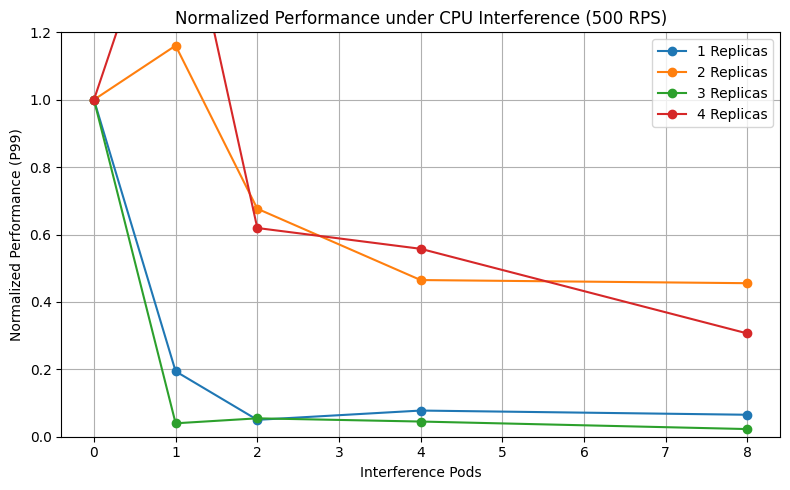

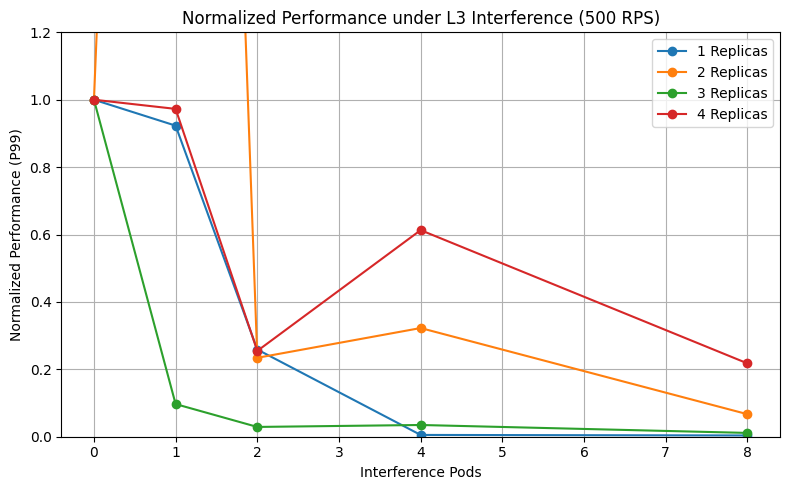

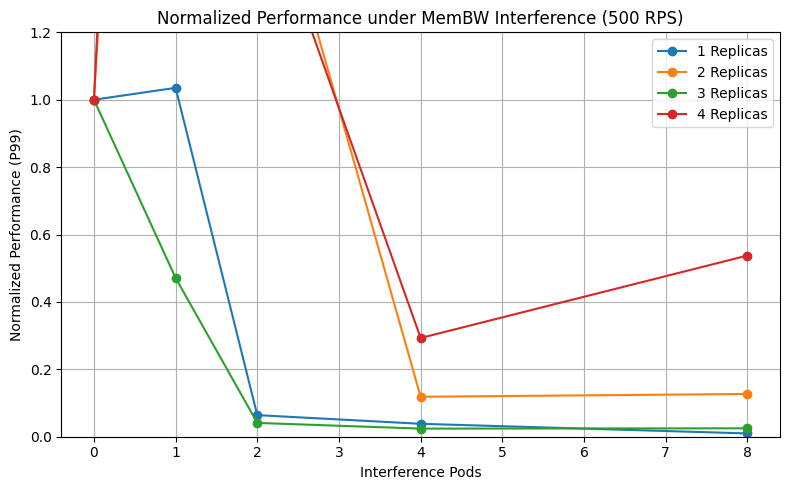

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


# Filter only 500 RPS entries
df_500 = df_perf[df_perf["Given_RPS"] == 1100].copy()

# Interference scenario structure
scenario_map = {
    "ibench-cpu": [(None, 0), ("1_iBench_CPU_pod", 1), ("2_iBench_CPU_pods", 2), ("4_iBench_CPU_pods", 4), ("8_iBench_CPU_pods", 8)],
    "stress-ng-l3": [(None, 0), ("1_stress-ng_l3_pod", 1), ("2_stress-ng_l3_pods", 2), ("4_stress-ng_l3_pods", 4), ("8_stress-ng_l3_pods", 8)],
    "ibench-membw": [(None, 0), ("1_iBench_memBW_pod", 1), ("2_iBench_memBW_pods", 2), ("4_iBench_memBW_pods", 4), ("8_iBench_memBW_pods", 8)],
}

# Step 1: Get minimum baseline P99 per replica count
baseline_df = df_500[df_500["Interference"].isin(["Baseline0", "Baseline1"])]
baseline_p99 = baseline_df.groupby("Replicas")["P99_Latency"].min()

print("Baseline P99 Latency for each replica count:")
print(baseline_p99)

# Step 2: Build normalized performance DataFrame for each type
def build_normalized_df(interf_type):
    data = []
    for name, count in scenario_map[interf_type]:
        for replica in sorted(df_500["Replicas"].unique()):
            if name is None:
                # Baseline (0 pods)
                p99 = baseline_p99.get(replica)
                norm_perf = 1.0
            else:
                row = df_500[(df_500["Interference"] == name) & (df_500["Replicas"] == replica)]
                if row.empty:
                    continue
                p99 = row.iloc[0]["P99_Latency"]
                baseline = baseline_p99.get(replica)
                if pd.isna(baseline) or baseline == 0:
                    continue
                norm_perf = baseline / p99
            data.append({
                "Pods": count,
                "Replicas": replica,
                "Normalized_Performance": norm_perf
            })
    return pd.DataFrame(data)

# Step 3: Create the three DataFrames
df_cpu = build_normalized_df("ibench-cpu")
df_l3 = build_normalized_df("stress-ng-l3")
df_membw = build_normalized_df("ibench-membw")

# Step 4: Plotting function
def plot_normalized_perf(df, title):
    plt.figure(figsize=(8, 5))
    for replica in sorted(df["Replicas"].unique()):
        subset = df[df["Replicas"] == replica].sort_values("Pods")
        plt.plot(subset["Pods"], subset["Normalized_Performance"], marker='o', label=f"{replica} Replicas")
    plt.xlabel("Interference Pods")
    plt.ylabel("Normalized Performance (P99)")
    plt.title(title)
    plt.ylim(0, 1.2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 5: Draw the plots
plot_normalized_perf(df_cpu, "Normalized Performance under CPU Interference (500 RPS)")
plot_normalized_perf(df_l3, "Normalized Performance under L3 Interference (500 RPS)")
plot_normalized_perf(df_membw, "Normalized Performance under MemBW Interference (500 RPS)")


### 2.2 QoS Degradation
**Formula:**  
$$
\mathrm{QoS\_Degrad\%} \;=\; \frac{\mathrm{Perf}_{\text{with-intf}} \;-\; \mathrm{Perf}_{\text{alone}}}{\mathrm{Perf}_{\text{alone}}} \times 100\%
$$
**Usage**  
- Reports the **absolute** (or percentage) change in your QoS metric (e.g. +20 ms p90).  
- Ideal for capacity-planning (“each co-tenant adds this many milliseconds of tail latency”).

**Why We Need It**  
- Conveys the **magnitude** of slowdown in concrete units.  
- Helps operators budget additional latency and plan SLAs.

### 2.3 SLO Violation

**Formula:**  
$$
\mathrm{SLO\_ViolRate} \;=\; \frac{\bigl|\{\text{requests with latency} > \text{SLO\_threshold}\}\bigr|}{\text{total requests}}
$$

**Usage**  
- Measures the **fraction** (or count) of requests that breach your latency SLO.  
- Reported as a % or per-million rate, often over time or per scenario.

**Why We Need It**  
- Directly ties interference to user-visible failures or timeouts.  
- Captures threshold effects where small latency shifts cause large violation spikes.

### 2.4 Interference Sensitivity

**Formula**  
$$
\mathrm{Sensitivity} \;=\; \frac{\mathrm{Perf}_{\text{alone}} - \mathrm{Perf}_{\text{with-intf}}}{\mathrm{Perf}_{\text{alone}}}
\;=\; 1 \;-\; \mathrm{NormalizedPerf}
$$

**Usage**  
- Ranks workloads by **percent degradation** under interference.  
- Drives scheduler heuristics: e.g. “never co-locate two pods with > 30 % sensitivity.”  
- Plots as a single “pain score” per interference scenario.

**Why We Need It**  
- A concise score of how badly each service suffers.  
- Simplifies placement decisions by collapsing multiple metrics into one.  
- Highlights which pods need strongest isolation or resource guarantees.

##  3 Profiling: 

### **Given the state of the Server, what will the effect on the Application's Perfomance be?**

### 3.1. Application Profiling (Feature Extraction)

**Objective:** For each interference scenario, aggregate high-resolution PCM counters into a fixed set of summary features.  
- Compute the **mean** and **95th percentile** for each numeric counter (IPC, cache misses, memory bandwidth, C-state residencies, etc.).  
- Label each feature vector with its `Interference` scenario name so we can join later.

**Why calculate p95?**

When summarizing high-resolution counter streams into fixed features, the **mean** captures average behavior but can miss intermittent yet impactful bursts. Computing the **95th percentile** for each metric (e.g., IPC, cache misses, memory bandwidth) lets us quantify those sustained high-interference windows without over-reacting to single outliers.  
- **Captures “Spikiness”**: If a resource experiences occasional but prolonged contention, the 95th percentile rises, signaling potential tail-latency issues.  
- **Predicts Tail Latency**: Rare but sustained high counter values often drive P99 latency spikes. Including a high-percentile feature gives our model the ability to link resource “bursts” to service-level objective (SLO) violations.  
- **Robustness**: Unlike the maximum, the 95th percentile is less sensitive to one-off anomalies, yet still focuses on the worst 5% of the sampling windows—precisely the behavior most correlated with tail performance degradation.



In [38]:
def extract_pcm_features(data_dir, target_cores=[3,4,5], include_system=False, 
                        window_size=2, stats=('mean','p95','std')):
    """
    Extract PCM features from core and optionally system CSV logs.
    
    Parameters:
    - data_dir (str): Directory containing PCM CSV files
    - target_cores (list): Core numbers to analyze (default: [3,4,5])
    - include_system (bool): Whether to include system-wide metrics
    - window_size (int): Samples for rolling window
    - stats (tuple): Statistics to compute ('mean','p95','std','max','min')
    
    Returns:
    - pd.DataFrame: One row per scenario, features + pcm_id
    """
    # Pattern to match both core and system files
    core_pattern = os.path.join(data_dir, 'pcm_core_*.csv')
    system_pattern = os.path.join(data_dir, 'pcm_system_*.csv')
    
    # Get all available files
    core_files = glob.glob(core_pattern)
    system_files = glob.glob(system_pattern) if include_system else []
    
    if not core_files and not system_files:
        print(f"⚠️ No PCM files found in {data_dir}")
        return pd.DataFrame()

    # Create mapping of scenario IDs to their features
    features_dict = {}

    # Process core files
    for filepath in core_files:
        # Extract pcm_id (e.g., "2replicas_scenario9_900rps" from "pcm_core_2replicas_scenario9_900rps.csv")
        pcm_id = os.path.basename(filepath).replace('pcm_core_', '').replace('.csv', '')
        
        if pcm_id not in features_dict:
            features_dict[pcm_id] = {'Test_ID': pcm_id}
            
        df_pcm = pd.read_csv(filepath)
        
        # Process target cores
        for core in target_cores:
            core_prefix = f'Core{core} (Socket 0) - '
            core_cols = [col for col in df_pcm.columns if col.startswith(core_prefix)]
            
            # Filter to metrics we care about
            keep_metrics = ['IPC', 'L3MISS', 'L2MISS', 'C0res%', 'C1res%', 'C6res%']
            core_cols = [col for col in core_cols if any(m in col for m in keep_metrics)]
            
            for col in core_cols:
                metric = col.replace(core_prefix, '').replace('%', '')
                clean_name = f'Core{core}_{metric}'
                s = df_pcm[col]
                
                # Compute statistics
                stats_results = compute_windowed_stats(s, window_size, stats)
                for stat, value in stats_results.items():
                    features_dict[pcm_id][f'{stat}_{clean_name}'] = value

    # Process system files if requested
    if include_system:
        for filepath in system_files:
            pcm_id = os.path.basename(filepath).replace('pcm_system_', '').replace('.csv', '')
            
            if pcm_id not in features_dict:
                features_dict[pcm_id] = {'pcm_id': pcm_id}
                
            df_sys = pd.read_csv(filepath)
            
            # Filter system metrics (excluding core-specific and unwanted metrics)
            sys_cols = [col for col in df_sys.columns 
                       if 'Core' not in col and 
                       not any(x in col for x in ["System Pack C-States", "PhysIPC%"])]
            
            for col in sys_cols:
                if ' - ' in col:
                    metric = col.split(' - ')[1].replace('%', '')
                    clean_name = f'Sys_{metric}'
                else:
                    clean_name = f'Sys_{col}'
                    
                s = df_sys[col]
                stats_results = compute_windowed_stats(s, window_size, stats)
                for stat, value in stats_results.items():
                    features_dict[pcm_id][f'{stat}_{clean_name}'] = value

    # Convert to DataFrame
    df_features = pd.DataFrame(features_dict.values())
    
    print(f"Extracted {len(df_features.columns)-1} features from {len(features_dict)} scenarios")
    return df_features

def compute_windowed_stats(series, window_size, stats):
    """Helper function to compute windowed statistics"""
    results = {}
    
    if window_size:
        win = series.rolling(window=window_size, center=True, min_periods=1)
        if 'mean' in stats: results['mean'] = win.mean().mean()
        if 'std' in stats: results['std'] = win.std().mean()
        if 'max' in stats: results['max'] = win.max().mean()
        if 'min' in stats: results['min'] = win.min().mean()
        if 'p95' in stats: results['p95'] = win.quantile(0.95).mean()
    else:
        if 'mean' in stats: results['mean'] = series.mean()
        if 'std' in stats: results['std'] = series.std()
        if 'max' in stats: results['max'] = series.max()
        if 'min' in stats: results['min'] = series.min()
        if 'p95' in stats: results['p95'] = series.quantile(0.95)
    
    return results

In [39]:
df_features_HR = extract_pcm_features(Data_Dir, target_cores=[3,4,5])
display(df_features_HR)

Extracted 63 features from 490 scenarios


,Test_ID,mean_Core3_IPC,std_Core3_IPC,p95_Core3_IPC,mean_Core3_L3MISS,std_Core3_L3MISS,p95_Core3_L3MISS,mean_Core3_L2MISS,std_Core3_L2MISS,p95_Core3_L2MISS,...,p95_Core5_C0res,mean_Core5_C1res,std_Core5_C1res,p95_Core5_C1res,mean_Core5_C6res,std_Core5_C6res,p95_Core5_C6res,mean_Core5_PhysIPC,std_Core5_PhysIPC,p95_Core5_PhysIPC
0,1replicas_scenario3_2500rps,1.146667,0.160867,1.237667,0.013333,0.001768,0.014333,0.193333,0.022981,0.206333,...,7.318111,91.370556,2.238877,92.637056,0.0,0.0,0.0,61.217778,0.602809,61.558778
1,4replicas_scenario0_100rps,0.736111,0.138770,0.814611,0.052222,0.012374,0.059222,0.144444,0.024749,0.158444,...,1.921944,77.049444,2.855828,78.664944,0.0,0.0,0.0,27.432222,3.413558,29.363222
2,4replicas_scenario5_900rps,1.555000,0.011571,1.561750,0.024583,0.008357,0.029458,0.242500,0.077139,0.287500,...,7.094708,92.907917,0.004500,92.910542,0.0,0.0,0.0,62.923750,0.264201,63.077875
3,3replicas_scenario6_2500rps,0.819167,0.079710,0.865667,0.054167,0.009000,0.059417,0.499167,0.088710,0.550917,...,0.766625,95.321250,5.298801,98.412375,0.0,0.0,0.0,31.529167,1.315219,32.296417
4,2replicas_scenario1_900rps,0.786667,0.123422,0.858667,0.020000,0.000000,0.020000,0.130833,0.017999,0.141333,...,0.386125,71.527917,1.305576,72.289542,0.0,0.0,0.0,40.675417,2.317382,42.027292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,4replicas_scenario9_2100rps,0.358333,0.025633,0.372833,2.123889,0.552427,2.436389,7.880000,0.889187,8.383000,...,13.923000,86.172222,0.171473,86.269222,0.0,0.0,0.0,10.436111,0.566569,10.756611
486,3replicas_scenario12_1300rps,1.195833,0.060425,1.231083,0.038750,0.005785,0.042125,0.135417,0.040498,0.159042,...,6.477792,82.540000,4.141074,84.955750,0.0,0.0,0.0,42.005000,2.705005,43.583000
487,3replicas_scenario3_100rps,1.290000,0.091924,1.342000,0.006111,0.004419,0.008611,0.052222,0.008839,0.057222,...,3.230667,78.874444,1.506137,79.726444,0.0,0.0,0.0,62.772778,0.338527,62.964278
488,3replicas_scenario9_1300rps,0.413889,0.053917,0.444389,0.902778,0.168822,0.998278,4.342778,0.296101,4.510278,...,13.926833,86.062222,0.028284,86.078222,0.0,0.0,0.0,10.411667,0.451664,10.667167


### 3.2. Label Joining & Normalized Performance

**Objective:**  
Merge each hardware‐counter feature vector (`df_features`) with its corresponding observed tail‐latency, then convert raw latencies into a _normalized slowdown ratio_ that becomes our RiskScore target (`norm_perf`).

**Steps:**

1. **Extract per-traffic baseline latency and Compute slowdown ratio**  
    - For each `Interference` scenario, extract the baseline latency (e.g. P99) from the row where `Interference = "baseline"`.  
    - Compute the slowdown ratio:  
      ```python
      df_perf['Normalized_Performance'] = df_perf['P99_Latency'] / df_perf['Baseline_P99_Latency']
      ```
    - This gives us a measure of how much worse the latency is under interference compared to the baseline.

3. **Merge with features and set RiskScore**  
   - Inner‐join your feature table on the `Interference` column
   - The resulting `df_ml` contains one row per experiment, with:
     - all hardware‐counter summaries
     - the normalized target `norm_perf` (Risk < 1 ⇒ likely SLO violation)

**Why use norm_perf column?**  
- **Workload-agnostic target:** by normalizing against each test’s own baseline, the model doesn’t need to learn absolute latencies for every traffic pattern—only how much interference slows it down.  
- **Aligned with SLOs:** `norm_perf` becomes a direct proxy for “fraction of SLO consumed” (e.g. predicted P99 / SLO_ms), so a learned model can output a true RiskScore that the scheduler uses to decide placement or mitigation.


In [40]:
Perfomance_File = os.path.join(Data_Dir, 'workload_metrics.csv')


if os.path.exists(Perfomance_File):
    df_perf = pd.read_csv(Perfomance_File)

In [41]:
def calculate_norm_perf(df_perf, latency_col='P99_Latency'):
    """
    Calculate normalized performance using mean baseline values for each replica+RPS combination.
    Preserves original DataFrame structure while computing correct normalized values.
    
    Args:
        df_perf: DataFrame containing performance data
        latency_col: The latency column to use for normalization (default: 'P99_Latency')
    
    Returns:
        DataFrame with added 'norm_perf' column
    """
    # Create a copy to avoid modifying original
    df = df_perf.copy()
    
    # Calculate mean baseline for each replica+RPS combination
    baseline_means = (df[df['Interference'].str.startswith('Baseline')]
                     .groupby(['Replicas', 'Given_RPS'])[latency_col]
                     .mean()
                     .reset_index()
                     .rename(columns={latency_col: 'baseline_mean'}))
    
    # Merge with original data
    df = df.merge(baseline_means, on=['Replicas', 'Given_RPS'], how='left')
    
    # Calculate normalized performance
    df['norm_perf'] = df['baseline_mean'] / df[latency_col]
    
    # Drop temporary column
    #df.drop(columns=['baseline_mean'], inplace=True)
    
    return df

# Usage:
df_perf = calculate_norm_perf(df_perf, 'P99_Latency')
display(df_perf)

,Test_ID,Replicas,Interference,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency,baseline_mean,norm_perf
0,1replicas_scenario0_100rps,1,Baseline0,100,95.02,87.05,65.0,95.0,128.0,327.0,1240.0,958.5,2.931193
1,1replicas_scenario0_500rps,1,Baseline0,500,495.00,92.98,67.0,102.0,158.0,345.0,2610.0,1402.5,4.065217
2,1replicas_scenario0_900rps,1,Baseline0,900,894.99,115.47,57.0,93.0,127.0,1830.0,4830.0,1920.0,1.049180
3,1replicas_scenario0_1300rps,1,Baseline0,1300,1262.59,565.81,393.0,746.0,1210.0,2310.0,4240.0,1255.5,0.543506
4,1replicas_scenario0_1700rps,1,Baseline0,1700,1692.89,78.96,65.0,83.0,117.0,272.0,2330.0,1056.0,3.882353
...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,5replicas_scenario13_900rps,5,8_iBench_memBW_pods,900,872.55,1100.00,596.0,1430.0,2730.0,5770.0,11120.0,1795.0,0.311092
486,5replicas_scenario13_1300rps,5,8_iBench_memBW_pods,1300,1262.49,680.91,449.0,758.0,1430.0,3470.0,11720.0,1075.0,0.309798
487,5replicas_scenario13_1700rps,5,8_iBench_memBW_pods,1700,1654.92,1080.00,569.0,1350.0,2730.0,5750.0,11390.0,193.0,0.033565
488,5replicas_scenario13_2100rps,5,8_iBench_memBW_pods,2100,2042.44,654.68,470.0,771.0,1280.0,3160.0,9870.0,1825.0,0.577532


In [42]:
if not df_perf.empty and not df_features_HR.empty:
    df_ml = df_features_HR.merge(df_perf, on='Test_ID', how='inner')
    print("Combined ML-ready dataset:")
    display(df_ml)
else:
    df_ml = pd.DataFrame()
    print("⚠️ Cannot create ML dataset: missing performance or feature data.")

# Show columns of the final dataset
print("Final dataset columns:")
print(df_ml.columns.tolist())

Combined ML-ready dataset:


,Test_ID,mean_Core3_IPC,std_Core3_IPC,p95_Core3_IPC,mean_Core3_L3MISS,std_Core3_L3MISS,p95_Core3_L3MISS,mean_Core3_L2MISS,std_Core3_L2MISS,p95_Core3_L2MISS,...,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency,baseline_mean,norm_perf
0,1replicas_scenario3_2500rps,1.146667,0.160867,1.237667,0.013333,0.001768,0.014333,0.193333,0.022981,0.206333,...,2500,2490.92,171.12,84.0,155.0,257.0,2170.0,5070.0,979.0,0.451152
1,4replicas_scenario0_100rps,0.736111,0.138770,0.814611,0.052222,0.012374,0.059222,0.144444,0.024749,0.158444,...,100,95.02,101.55,77.0,119.0,159.0,340.0,1420.0,895.0,2.632353
2,4replicas_scenario5_900rps,1.555000,0.011571,1.561750,0.024583,0.008357,0.029458,0.242500,0.077139,0.287500,...,900,894.99,286.70,61.0,97.0,940.0,3440.0,7530.0,2035.0,0.591570
3,3replicas_scenario6_2500rps,0.819167,0.079710,0.865667,0.054167,0.009000,0.059417,0.499167,0.088710,0.550917,...,2500,2490.98,84.40,77.0,95.0,119.0,199.0,1690.0,1975.0,9.924623
4,2replicas_scenario1_900rps,0.786667,0.123422,0.858667,0.020000,0.000000,0.020000,0.130833,0.017999,0.141333,...,900,872.55,382.26,278.0,475.0,834.0,1430.0,3320.0,889.5,0.622028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,4replicas_scenario9_2100rps,0.358333,0.025633,0.372833,2.123889,0.552427,2.436389,7.880000,0.889187,8.383000,...,2100,2092.03,399.69,264.0,422.0,742.0,2410.0,10040.0,931.5,0.386515
486,3replicas_scenario12_1300rps,1.195833,0.060425,1.231083,0.038750,0.005785,0.042125,0.135417,0.040498,0.159042,...,1300,1262.54,555.96,342.0,639.0,1260.0,3190.0,6150.0,1380.0,0.432602
487,3replicas_scenario3_100rps,1.290000,0.091924,1.342000,0.006111,0.004419,0.008611,0.052222,0.008839,0.057222,...,100,95.02,151.48,78.0,119.0,173.0,2140.0,4160.0,865.5,0.404439
488,3replicas_scenario9_1300rps,0.413889,0.053917,0.444389,0.902778,0.168822,0.998278,4.342778,0.296101,4.510278,...,1300,1262.54,1180.00,825.0,1370.0,2330.0,5980.0,16880.0,1380.0,0.230769


Final dataset columns:
['Test_ID', 'mean_Core3_IPC', 'std_Core3_IPC', 'p95_Core3_IPC', 'mean_Core3_L3MISS', 'std_Core3_L3MISS', 'p95_Core3_L3MISS', 'mean_Core3_L2MISS', 'std_Core3_L2MISS', 'p95_Core3_L2MISS', 'mean_Core3_C0res', 'std_Core3_C0res', 'p95_Core3_C0res', 'mean_Core3_C1res', 'std_Core3_C1res', 'p95_Core3_C1res', 'mean_Core3_C6res', 'std_Core3_C6res', 'p95_Core3_C6res', 'mean_Core3_PhysIPC', 'std_Core3_PhysIPC', 'p95_Core3_PhysIPC', 'mean_Core4_IPC', 'std_Core4_IPC', 'p95_Core4_IPC', 'mean_Core4_L3MISS', 'std_Core4_L3MISS', 'p95_Core4_L3MISS', 'mean_Core4_L2MISS', 'std_Core4_L2MISS', 'p95_Core4_L2MISS', 'mean_Core4_C0res', 'std_Core4_C0res', 'p95_Core4_C0res', 'mean_Core4_C1res', 'std_Core4_C1res', 'p95_Core4_C1res', 'mean_Core4_C6res', 'std_Core4_C6res', 'p95_Core4_C6res', 'mean_Core4_PhysIPC', 'std_Core4_PhysIPC', 'p95_Core4_PhysIPC', 'mean_Core5_IPC', 'std_Core5_IPC', 'p95_Core5_IPC', 'mean_Core5_L3MISS', 'std_Core5_L3MISS', 'p95_Core5_L3MISS', 'mean_Core5_L2MISS', 'std_Co

### 3.3. Preprocessing & Pipeline Construction

**Objective:**  
Turn our raw hardware‐counter summaries into a compact, consistent input for a regressor that predicts the slowdown ratio (`Risk_obs`), while avoiding overfitting on just 24 experiments.

---

#### 1. Feature Selection  
- **Include all sliding-window stats:**  
  - `mean_`, `std_`, `p95_`  
- **Why?** These five measures per counter capture central tendency, variability, peaks, troughs, and tail‐behavior bursts—key signals for tail-latency.

#### 2. The Pipeline & Its Steps  
- **StandardScaler**: Normalize each feature to zero mean and unit variance.
- **PolynomialFeatures**: Expand the feature set with polynomial combinations of the original features.
- **PCA**: Reduce dimensionality while preserving variance.
- **RandomForestRegressor**: Train a regression model to predict the slowdown ratio.


In [43]:
from sklearn.decomposition import PCA

# 1. Identify feature columns and target
stat_prefixes = ('mean_', 'std_', 'p95_')
feature_cols = [c for c in df_ml.columns if c.startswith(stat_prefixes)]
# Group by replica count and train separate models
models = {}
for replicas, group in df_ml.groupby('Replicas'):
    X = group[feature_cols]
    y = group['norm_perf']
    
    model_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('pca', PCA(n_components=20, random_state=42)),
        ('reg', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    model_pipeline.fit(X, y)
    models[replicas] = model_pipeline

# 4. (Optional) Inspect explained variance of the components
explained = model_pipeline.named_steps['pca'].explained_variance_ratio_.sum()
print(f"Retained {explained:.1%} of variance in 20 components")

Retained 92.0% of variance in 20 components


### 3.4 Model Training & Evaluation

**Objective:**  
Assess how well our pipeline predicts the normalized slowdown (`norm_perf`) on interference scenarios it hasn’t seen, and quantify the expected error.

1. **Cross-Validation Strategy**  
   - We use **Leave-One-Interference-Level-Out** (LeaveOneGroupOut) CV, grouping by the `Interference` label.  
   - Each fold trains on all but one interference intensity (e.g. CPU×2, MemBW×4, etc.) and tests on the held-out level—mimicking how we need to generalize to new contention patterns.

2. **Scoring Metrics**  
   - **Mean Squared Error (MSE):** penalizes large deviations heavily; tells us how far off our predicted slowdown is, on average, in squared units.  
   - **Mean Absolute Error (MAE):** more interpretable “on average we’re ±X% off” in the slowdown ratio.

3. **Interpreting Results**  
   - A low MAE (e.g. 0.05) means we predict that a node’s tail latency will be within 5% of its true slowdown.  
   - These errors guide confidence in scheduling decisions: if the predicted slowdown differences between two nodes exceed our MAE, we can reliably pick the best node.

4. **Scheduler Integration**  
   - At runtime, the scheduler will load this **trained pipeline**, sample live hardware counters on each node, and compute `predicted_norm_perf`.  
   - It then assigns new pods to the node with the lowest predicted slowdown, or triggers mitigation if all nodes exceed an acceptable threshold.

By successfully completing this subsection, we’ll have a validated, quantifiable predictor of interference-induced slowdowns—our RiskScore—that the scheduler can trust for placement decisions.  


In [44]:
from sklearn.model_selection import cross_validate, LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
import pandas as pd

# Initialize storage for results
all_results = []

# Define scorers
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'MAE': make_scorer(mean_absolute_error)
}

# Process each replica count separately
for replicas, group in df_ml.groupby('Replicas'):
    print(f"\n=== Processing Replica Count: {replicas} ===")
    
    # Features & target for this replica count
    X = group[[c for c in group.columns if c.startswith(stat_prefixes)]]
    y = group['norm_perf']
    groups = group['Interference']
    
    # Define CV splitter - leaving one interference type out each time
    logo = LeaveOneGroupOut()
    
    # Perform cross-validation
    cv_results = cross_validate(
        model_pipeline, X, y,
        cv=logo.split(X, y, groups=groups),
        scoring=scoring,
        return_train_score=False
    )
    
    # Store results with replica count information
    results_df = pd.DataFrame({
        'Replicas': replicas,
        'Fold': range(len(cv_results['test_MSE'])),
        'MSE': cv_results['test_MSE'],
        'MAE': cv_results['test_MAE']
    })
    all_results.append(results_df)
    
    # Print summary for this replica count
    print(f"Results for Replicas={replicas}:")
    print(f"  Average MSE: {cv_results['test_MSE'].mean():.4f}")
    print(f"  Average MAE: {cv_results['test_MAE'].mean():.4f}")
    print(f"  Number of samples: {len(group)}")

# Combine all results
final_results = pd.concat(all_results)

# Optional: Print overall statistics
print("\n=== Overall Summary ===")
print(final_results.groupby('Replicas')[['MSE', 'MAE']].mean())


=== Processing Replica Count: 1 ===
Results for Replicas=1:
  Average MSE: 1.2987
  Average MAE: 0.9221
  Number of samples: 98

=== Processing Replica Count: 2 ===
Results for Replicas=2:
  Average MSE: 0.9567
  Average MAE: 0.7359
  Number of samples: 98

=== Processing Replica Count: 3 ===
Results for Replicas=3:
  Average MSE: 4.4848
  Average MAE: 1.4056
  Number of samples: 98

=== Processing Replica Count: 4 ===
Results for Replicas=4:
  Average MSE: 3.3650
  Average MAE: 1.3033
  Number of samples: 98

=== Processing Replica Count: 5 ===
Results for Replicas=5:
  Average MSE: 2.0553
  Average MAE: 0.9083
  Number of samples: 98

=== Overall Summary ===
               MSE       MAE
Replicas                    
1         1.298672  0.922128
2         0.956670  0.735861
3         4.484821  1.405643
4         3.365001  1.303333
5         2.055276  0.908344


### 3.5 Testing the Predictor on Real Data

**Goal:** Given a fresh PCM trace, forecast its slowdown and compare it against the single observed P90 latency.

1. **Feature Extraction**  
   - We call `extract_pcm_features(...)` on the `HR_Test` folder to compute the same sliding-window stats used during training.

2. **Prediction**  
   - We pass those stats into `model_pipeline.predict(...)` and capture `predicted_Risk`, our model’s estimate of slowdown (e.g., 5× slower than baseline).

3. **Observe True P90**  
   - We read the lone `P90_Latency` value from `workload_metrics.csv` (e.g., 46970 ms).

4. **Baseline Reference**  
   - We fetch the original baseline P90 (9430 ms) from our training DataFrame (`df_perf`), without relying on labels in the test CSV.

5. **Compute Actual Slowdown**  
   - `actual_Risk = observed_p90 / baseline_p90` (e.g., 46970 / 9430 ≈ 4.98).

6. **Comparison**  
   - Present a simple table showing `predicted_Risk` vs. `actual_Risk`.  
   - Close agreement validates that our offline-trained pipeline delivers reliable slowdown estimates for scheduler decision-making.


In [ ]:
import os
import pandas as pd

# --- 1. Extract PCM features for the test run ---
test_dir   = "Nginx_Test"
traffic_id = "light-test_cpu_1_l3_1"      # matches the suffix in pcm_system_metrics_TC-VM-01_test.csv
window_size = 5              # same window size used during training
stats       = ('mean','std','p95')

df_test_feat = extract_pcm_features(
    data_dir=test_dir
)

# --- 2. Predict slowdown ratio with the trained pipeline ---
feature_cols = [c for c in df_test_feat.columns if c.startswith(('mean_','std_','p95_'))]
X_test        = df_test_feat[feature_cols]
predicted_risk = model_pipeline.predict(X_test)[0]

# --- 3. Load the observed P90 latency for this test run ---
df_workload = pd.read_csv(os.path.join(test_dir, "workload_metrics.csv"))
observed_p90 = df_workload["P99_Latency"].iloc[0]    # e.g. 46970.0 ms

# --- 4. Look up the baseline P90 latency from the training data (df_perf) ---
baseline_p90 = 638.0 ## Medium Traffic - Baseline P90 Latency

# --- 5. Compute the actual slowdown ratio ---
actual_risk = baseline_p90 / observed_p90

# --- 6. Display predicted vs. actual slowdown ---
error_percent = 100 * abs(predicted_risk - actual_risk) / actual_risk

result = pd.DataFrame({
    "predicted_Risk": [predicted_risk],
    "actual_Risk":    [actual_risk],
    "error_percent":  [error_percent]
})
print("Predicted vs. Actual Slowdown Ratios:")
display(result)


Extracted 63 features from 1 scenarios
Predicted vs. Actual Slowdown Ratios:


,predicted_Risk,actual_Risk,error_percent
0,1.868313,0.425333,339.258653


## 4. Exporting the Predictor

In [22]:
import joblib
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [23]:
# 1. Export the model pipeline and feature information
def export_predictor(df_ml, model_pipeline, feature_cols, filename='slowdown_predictor'):
    """
    Exports the complete predictor pipeline with all required metadata
    
    Args:
        df_ml: Your training DataFrame
        model_pipeline: The trained pipeline
        feature_cols: List of feature columns used
        filename: Base filename for exports
    """
    # Create export package
    export_data = {
        'model': model_pipeline,
        'feature_columns': feature_cols,
        'stat_prefixes': ('mean_', 'std_', 'p95_'),
        'input_requirements': {
            'required_features': feature_cols,
            'expected_ranges': {
                col: (df_ml[col].min(), df_ml[col].max())
                for col in feature_cols
            }
        },
        'pca_components': {
            'n_components': model_pipeline.named_steps['pca'].n_components,
            'explained_variance': model_pipeline.named_steps['pca'].explained_variance_ratio_,
            'total_variance': model_pipeline.named_steps['pca'].explained_variance_ratio_.sum()
        },
        'model_metadata': {
            'type': 'RandomForestRegressor',
            'n_estimators': model_pipeline.named_steps['reg'].n_estimators,
            'features_count': len(feature_cols),
            'polynomial_degree': model_pipeline.named_steps['poly'].degree
        }
    }
    
    # Save the complete package
    joblib.dump(export_data, f'{filename}_full.pkl')
    
    # Save lightweight version for production (just model + features)
    joblib.dump({
        'model': model_pipeline,
        'feature_columns': feature_cols
    }, f'{filename}_lite.pkl')
    
    print(f"Exported predictor to {filename}_full.pkl and {filename}_lite.pkl")
    print(f"PCA retains {export_data['pca_components']['total_variance']:.1%} of variance")

# 2. Add this to your notebook after model training
# Assuming you have:
# - df_ml: Your training DataFrame
# - model_pipeline: Your trained pipeline
# - feature_cols: List of feature columns used

export_predictor(
    df_ml=df_ml,
    model_pipeline=model_pipeline,
    feature_cols=feature_cols,
    filename='slowdown_predictor'
)


Exported predictor to slowdown_predictor_full.pkl and slowdown_predictor_lite.pkl
PCA retains 99.9% of variance


In [24]:
# 3. Verify the export (optional)
def load_predictor(filename='slowdown_predictor_lite.pkl'):
    """Helper function to verify the export"""
    data = joblib.load(filename)
    print("Loaded predictor with:")
    print(f"- {len(data['feature_columns'])} feature columns")
    print(f"- Model type: {type(data['model']).__name__}")
    return data

# Test loading
test_load = load_predictor()

Loaded predictor with:
- 24 feature columns
- Model type: Pipeline
